# Introduction to Theano

## 0. Initialization

In order to enable tqdm progress bar widget run

`jupyter nbextension enable --py widgetsnbextension`

and restart Jupyter notebook

to have plots inlined in Jupyter:

In [1]:
%matplotlib inline

To store generated visualization files:

In [2]:
try:
    import os
    os.makedirs('out')
except OSError:
    pass

Visualizations in jupyter:

In [3]:
from IPython.display import Image, IFrame

Progress bar for Jupyter:

In [4]:
from tqdm import tnrange, tqdm_notebook

## 1. Basics

### 1.1 Imports

In [5]:
from theano import pp, function, shared, In
from theano.tensor.shared_randomstreams import RandomStreams
from theano.printing import debugprint
from theano.printing import pydotprint
from theano.ifelse import ifelse
import theano.d3viz as d3v

import theano.tensor as T
import theano

from matplotlib import pyplot
import numpy as np

### 1.2 Config preview

In [6]:
print theano.config.mode
print theano.config.floatX
print theano.config.device

Mode
float32
cpu


### 1.3 Symbolic variables

In [7]:
s = T.scalar('s')
v = T.vector('v')
M = T.matrix('M')

In [8]:
s

s

In [9]:
s.type

TensorType(float32, scalar)

In [10]:
type(s)

theano.tensor.var.TensorVariable

### 1.4 Variable types

In [11]:
s = T.scalar('s')  # 0-dimensional ndarray
v = T.vector('v')  # 1-dimensional ndarray

r = T.row('r')  # 2-dimensional ndarray 
                # in which the number of rows is guaranteed to be 1
    
c = T.col('c')  # 2-dimensional ndarray 
                # in which the number of columns is guaranteed to be 1

m = T.matrix('m')     # 2-dimensional ndarray
t3 = T.tensor3('t3')  # 3-dimensional ndarray
t4 = T.tensor4('t4')  # 4-dimensional ndarray
t5 = T.tensor5('t5')  # 5-dimensional ndarray

Integer prefixes:
- **b-** byte (8)
- **w-** word (16)
- **i-** integer (32)
- **l-** long (64)

Floating point prefixes:
- **f-** float (32)
- **d-** double (64)

In [12]:
T.iscalar().type

TensorType(int32, scalar)

In [13]:
T.scalar(dtype='int32').type

TensorType(int32, scalar)

In [14]:
T.dscalar().type

TensorType(float64, scalar)

In [15]:
T.scalar(dtype='float64').type

TensorType(float64, scalar)

In [16]:
T.dscalar().type

TensorType(float64, scalar)

In [17]:
T.scalar().type

TensorType(float32, scalar)

In [18]:
fscalar = T.fscalar('fscalar')
fscalar.type is T.fscalar

True

### 1.5 Expressions

In [19]:
x = T.dscalar('x')
y = T.dscalar('y')
z = x + y

In [20]:
z

Elemwise{add,no_inplace}.0

In [21]:
pp(z)

'(x + y)'

In [22]:
debugprint(z)

Elemwise{add,no_inplace} [id A] ''   
 |x [id B]
 |y [id C]


First time will be slow, expression is being compiled to C code

In [23]:
z.eval({x: 2, y: 2})

array(4.0)

Next evaluation is much faster, compiled expression is cached

In [24]:
z.eval({x: 10, y: 20})

array(30.0)

In [25]:
dx = T.grad(x ** 2 + y, x)
dx.eval({x: 2, y: 2})

array(4.0)

In [26]:
debugprint(dx)

Elemwise{mul} [id A] ''   
 |Elemwise{mul} [id B] ''   
 | |Elemwise{second,no_inplace} [id C] ''   
 | | |Elemwise{add,no_inplace} [id D] ''   
 | | | |Elemwise{pow,no_inplace} [id E] ''   
 | | | | |x [id F]
 | | | | |TensorConstant{2} [id G]
 | | | |y [id H]
 | | |TensorConstant{1.0} [id I]
 | |TensorConstant{2} [id G]
 |Elemwise{pow} [id J] ''   
   |x [id F]
   |Elemwise{sub} [id K] ''   
     |TensorConstant{2} [id G]
     |InplaceDimShuffle{} [id L] ''   
       |TensorConstant{1} [id M]


The output file is available at out/graph.png


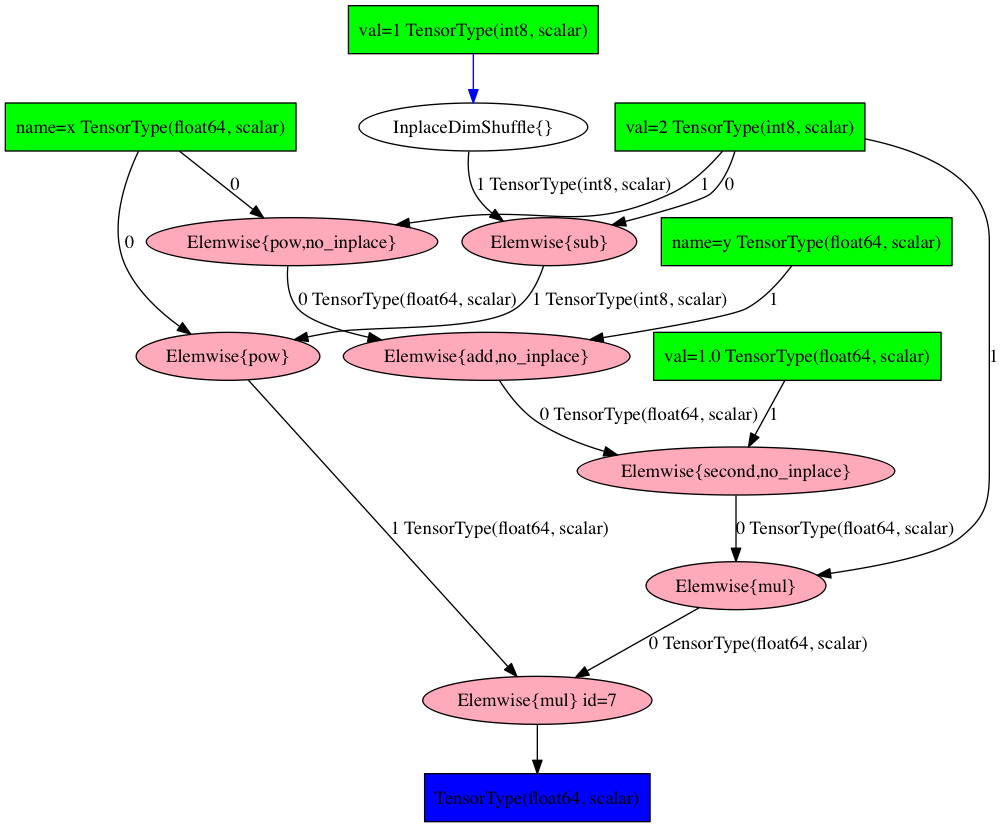

In [27]:
pydotprint(dx, outfile='out/graph.png')
Image('out/graph.png', width=1000)

In [28]:
d3v.d3viz(dx, 'out/graph.html')
IFrame('out/graph.html', width=700, height=500)

In [29]:
pp(dx)

'((fill(((x ** TensorConstant{2}) + y), TensorConstant{1.0}) * TensorConstant{2}) * (x ** (TensorConstant{2} - TensorConstant{1})))'

In [30]:
f = theano.function([x, y], dx)
pp(f.maker.fgraph.outputs[0])

'(TensorConstant{2.0} * x)'

### 1.6 Functions
Theano functions can act like python functions

In [31]:
f = function([x, y], z)

In [32]:
f(1, 2)

array(3.0)

Functions can output multiple values

In [33]:
f2 = function([x, y], [z, z**2])

In [34]:
f2(1, 2)

[array(3.0), array(9.0)]

Functions can have default values

In [35]:
f3 = function([x, In(y, value=1)], z)

In [36]:
f3(5)

array(6.0)

In [37]:
f3(5, 5)

array(10.0)

Functions can have kwargs

In [38]:
f4 = function([x, In(y, value=1, name='y')], z)

In [39]:
f4(5)

array(6.0)

In [40]:
f4(2, y=7)

array(9.0)

Givens can replace part of expression with something different

In [41]:
z1 = x * y
z2 = z + y
expression = z1 + z2

In [42]:
f1 = function([x, y], expression)

In [43]:
f1(1, 2)

array(7.0)

In [44]:
debugprint(f1)

Elemwise{Composite{((i0 * i1) + i0 + i2 + i1)}} [id A] ''   0
 |x [id B]
 |y [id C]
 |y [id C]


In [45]:
f2 = function([y], expression, givens=[(x, 5.0)])

In [46]:
f2(5)

array(40.0)

In [47]:
debugprint(f2)

Elemwise{Composite{((i0 * i1) + i0 + i2 + i1)}} [id A] ''   0
 |<TensorType(float64, scalar)> [id B]
 |y [id C]
 |y [id C]


In [48]:
f3 = function([x, y], expression, givens=[(z1, 0.0)])

In [49]:
f3(1, 2)

array(5.0)

In [50]:
debugprint(f3)

Elemwise{add,no_inplace} [id A] ''   0
 |<TensorType(float64, scalar)> [id B]
 |x [id C]
 |y [id D]
 |y [id D]


In [51]:
f4 = function([x], expression, givens=[(y, x)])

In [52]:
f4(5)

array(40.0)

In [53]:
debugprint(f4)

Elemwise{Composite{(sqr(i0) + i1 + i2 + i0)}} [id A] ''   0
 |x [id B]
 |x [id B]
 |x [id B]


### 1.7 Shared variables

In [54]:
state = shared(0)
value = T.iscalar('value')
accumulate = function([value], state, updates=[(state, state+value)])

In [55]:
state.get_value()

array(0)

In [56]:
accumulate(5)

array(0)

In [57]:
state.get_value()

array(5)

In [58]:
accumulate(2)

array(5)

In [59]:
state.get_value()

array(7)

In [60]:
state.set_value(0)

In [61]:
accumulate(2)

array(0)

In [62]:
state.get_value()

array(2)

### 1.8 Random numbers

In [63]:
random_number_generator = RandomStreams(seed=42)
uniform_variable = random_number_generator.uniform()
normal_variable = random_number_generator.normal()

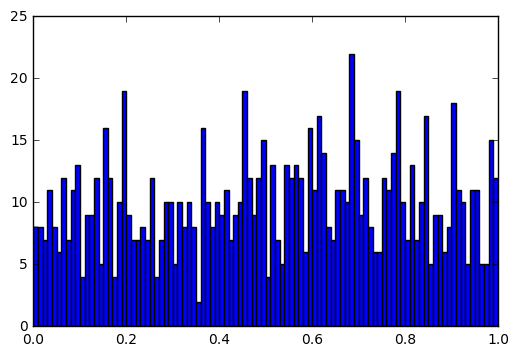

In [64]:
f1 = function([], uniform_variable)
pyplot.hist([f1() for _ in range(1000)], bins=100)
pyplot.show()

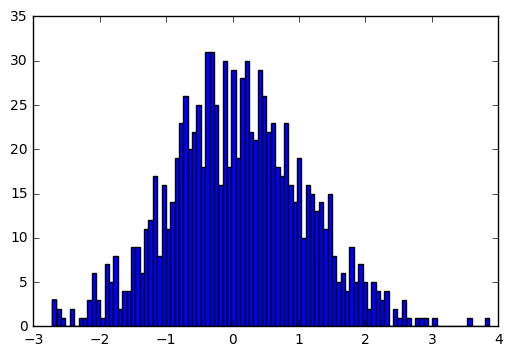

In [65]:
f2 = function([], normal_variable)
pyplot.hist([f2() for _ in range(1000)], bins=100)
pyplot.show()

In [66]:
f3 = function([], normal_variable, no_default_updates=True)
f3()  # constant value, running f2 changes rng state

array(-0.40367916226387024, dtype=float32)

### 1.9 Conditions

In [67]:
a, b = T.dscalars('a', 'b')
x, y = T.dmatrices('x', 'y')

Switch takes a tensor as condition, it is more general than ifelse 
but it evaluates both expressions

In [68]:
z_switch = T.switch(x < y, 5, 10)
z_switch.eval({x: np.random.random((2, 3)), y: np.random.random((2, 3))})

array([[10,  5,  5],
       [10, 10,  5]], dtype=int8)

IfElse takes a boolean as condition, it is less general than switch but it evaluates lazily one expression

In [69]:
z_ifelse = ifelse(a < b, 5, 10)
z_ifelse.eval({a: 4, b: 10})

array(5, dtype=int8)

### 1.10 Scan

Advantages of using scan over for loops:
- Number of iterations to be part of the symbolic graph.
- Minimizes GPU transfers (if GPU is involved).
- Computes gradients through sequential steps.
- Slightly faster than using a for loop in Python with a compiled Theano function.
- Can lower the overall memory usage by detecting the actual amount of memory needed.

Example: Calculating a Polynomial

In [70]:
x = T.scalar("x")
coefficients = theano.tensor.vector("coefficients")

powers = T.arange(coefficients.size)
components, updates = theano.scan(fn=lambda coeff, power, free_var:
                                     coeff * (free_var ** power),
                                  outputs_info=None,
                                  sequences=[coefficients, powers],
                                  non_sequences=x)

polynomial = components.sum()
calculate_polynomial = theano.function(inputs=[coefficients, x], outputs=polynomial)
test_coeff = np.asarray([1, 0, 2], dtype=np.float32)
print(calculate_polynomial(test_coeff, 3))

19.0


Example: Cumulative row sum

In [71]:
X = T.matrix('X')
s = T.vector('s')  # Initial value for the cumulative sum

output, updates = theano.scan(fn=lambda m_row, cumulative_sum:
                                 m_row + cumulative_sum,
                              sequences=[X],
                              outputs_info=[s])

f = theano.function(inputs=[X, s],
                    outputs=output,
                    updates=updates)

M_value = np.arange(9).reshape(3, 3).astype(theano.config.floatX)
s_value = np.zeros((3,), dtype=theano.config.floatX)
print M_value, '\n\n', f(M_value, s_value)

[[ 0.  1.  2.]
 [ 3.  4.  5.]
 [ 6.  7.  8.]] 

[[  0.   1.   2.]
 [  3.   5.   7.]
 [  9.  12.  15.]]


### 1.11 Broadcast
![broadcast visualization](broadcast.png "Broadcast")

In [72]:
M = T.dmatrix('M')
r = T.drow('r')
c = T.dcol('c')

In [73]:
M.broadcastable

(False, False)

In [74]:
r.broadcastable

(True, False)

In [75]:
c.broadcastable

(False, True)

In [76]:
np.arange(9).reshape(3, 3)

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [77]:
(M * r).eval({
    M: np.arange(9).reshape(3, 3),
    r: np.expand_dims(np.arange(3), 0)
})

array([[  0.,   1.,   4.],
       [  0.,   4.,  10.],
       [  0.,   7.,  16.]])

In [78]:
(M * c).eval({
    M: np.arange(9).reshape(3, 3),
    c: np.expand_dims(np.arange(3), 1)
})

array([[  0.,   0.,   0.],
       [  3.,   4.,   5.],
       [ 12.,  14.,  16.]])

If you want to have custom broadcast behavior or to have a type with more dimensions than 5 you can always create a custom tensor type

In [79]:
custom_type = T.TensorType('int32', [False, True, False, False, False, False])

In [80]:
x = custom_type('x')

In [81]:
x

x

## 2. Logistic regression example

In [82]:
features_count = 784
training_steps = 10000
training_sample_size = 400

# generate a dataset: D = (input_values, target_class)
D = (np.random.randn(training_sample_size, features_count), 
     np.random.randint(size=training_sample_size, low=0, high=2))

# Declare Theano symbolic variables
x = T.dmatrix("x")
y = T.dvector("y")

# initialize the weight vector w randomly
#
# this and the following bias variable b
# are shared so they keep their values
# between training iterations (updates)
w = theano.shared(np.random.randn(features_count), name="w")
b = theano.shared(0., name="b")

# Construct Theano expression graph
p_1 = 1 / (1 + T.exp(-T.dot(x, w) - b))  # Probability that target = 1
prediction = p_1 > 0.5  # The prediction thresholded
xent = -y * T.log(p_1) - (1-y) * T.log(1-p_1)  # Cross-entropy loss function
cost = xent.mean() + 0.01 * (w ** 2).sum()  # The cost to minimize
gw, gb = T.grad(cost, [w, b])  # Compute the gradient of the cost
                               # w.r.t weight vector w and bias term b

train = theano.function(inputs=[x,y],
                        outputs=[prediction, xent],
                        updates=((w, w - 0.1 * gw), (b, b - 0.1 * gb)))

predict = theano.function(inputs=[x], outputs=prediction)

# Train
for i in tnrange(training_steps):
    pred, err = train(D[0], D[1])

predictions = predict(D[0]).astype(int)
target_vs_predictions = zip(D[1], predictions)[:22]
print target_vs_predictions


[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (1, 1), (0, 0)]


## Appendix A: Debugging

### 1. Testing

In [83]:
A = T.matrix('A')
B = T.matrix('B')

In [84]:
C = A.dot(B)

Debugging can be painful

In [85]:
C.eval({
    A: np.random.random((3, 4)),
    B: np.random.random((5, 4))
})

TypeError: Bad input argument to theano function with name "<ipython-input-85-83d8960601c9>:3" at index 0 (0-based).  
Backtrace when that variable is created:

  File "/Users/mateuszopala/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/mateuszopala/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/mateuszopala/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/mateuszopala/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/mateuszopala/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/mateuszopala/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/mateuszopala/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-83-32423428ee31>", line 2, in <module>
    B = T.matrix('B')
TensorType(float32, matrix) cannot store a value of dtype float64 without risking loss of precision. If you do not mind this loss, you can: 1) explicitly cast your data to float32, or 2) set "allow_input_downcast=True" when calling "function". Value: "array([[ 0.29836164,  0.44915746,  0.81178857,  0.92651684],
       [ 0.19508799,  0.40873678,  0.21553673,  0.14162947],
       [ 0.51139009,  0.21328261,  0.08373738,  0.43679346],
       [ 0.56460042,  0.09188942,  0.03544012,  0.24556682],
       [ 0.31363215,  0.3292456 ,  0.97765639,  0.84844622]])"

Sometimes it is better to have errors at compile time

In [86]:
theano.config.compute_test_value = 'warn'  # enable test values
A.tag.test_value = np.random.random((3, 4)).astype(theano.config.floatX)
B.tag.test_value = np.random.random((5, 4)).astype(theano.config.floatX)

In [87]:
C = A.dot(B)

ValueError: shapes (3,4) and (5,4) not aligned: 4 (dim 1) != 5 (dim 0)

In [88]:
C2 = A.dot(B.T)

In [89]:
theano.config.compute_test_value = 'off'  # disable test values

### 2. Printing
It is possible to print variable values at runtime within theano function

In [90]:
uniform_variable = RandomStreams(seed=42).uniform()
x = T.dscalar('x')
z = x * uniform_variable
z_printed = theano.printing.Print('z value: ')(z)
f = theano.function([x], z_printed * 2)

In [91]:
f(2)

z value:  __str__ = 0.753175735474


array(1.5063514709472656)

### 3. Inspecting inputs and outputs

printing inputs and outputs

In [92]:
def inspect_inputs(i, node, fn):
    print i, node, "\n\tinput(s) value(s):", [input[0] for input in fn.inputs]

def inspect_outputs(i, node, fn):
    print "\toutput(s) value(s):", [output[0] for output in fn.outputs]

x = theano.tensor.dscalar('x')
f = theano.function([x], [5 * x ** 2 + x],
                    mode=theano.compile.MonitorMode(
                        pre_func=inspect_inputs,
                        post_func=inspect_outputs))

In [93]:
f(3)

0 Elemwise{Composite{((i0 * sqr(i1)) + i1)}}(TensorConstant{5.0}, x) 
	input(s) value(s): [array(5.0), array(3.0)]
	output(s) value(s): [array(48.0)]


[array(48.0)]

detecting nans

In [94]:
x = theano.tensor.dscalar('x')
f = theano.function([x], [theano.tensor.log(x) * x],
                    mode=theano.compile.MonitorMode(
                        post_func=theano.compile.monitormode.detect_nan))

In [95]:
f(0)  # log(0) * 0 = -inf * 0 = NaN

*** NaN detected ***
Elemwise{Composite{(log(i0) * i0)}} [id A] ''   
 |x [id B]
Inputs : [array(0.0)]
Outputs: [array(nan)]


[array(nan)]

## Appendix B: Profiling

In [96]:
features_count = 784
training_steps = 10000
training_sample_size = 400
D = (np.random.randn(training_sample_size, features_count), 
     np.random.randint(size=training_sample_size, low=0, high=2))
x = T.dmatrix("x")
y = T.dvector("y")
w = theano.shared(np.random.randn(features_count), name="w")
b = theano.shared(0., name="b")
p_1 = 1 / (1 + T.exp(-T.dot(x, w) - b))
prediction = p_1 > 0.5
xent = -y * T.log(p_1) - (1-y) * T.log(1-p_1)
cost = xent.mean() + 0.01 * (w ** 2).sum()
gw, gb = T.grad(cost, [w, b])
train = theano.function(inputs=[x,y], outputs=[prediction, xent], profile=True,
                        updates=((w, w - 0.1 * gw), (b, b - 0.1 * gb)))
predict = theano.function(inputs=[x], outputs=prediction)
for i in range(training_steps):
    pred, err = train(D[0], D[1])

notice "Toggle profile colors" button

In [97]:
d3v.d3viz(train, 'out/graph.html')
IFrame('out/graph.html', width=700, height=500)

## Appendix C: Optimizing

### 1. Adding shape info
Sometimes adding a shape info allows some computation optimization

In [98]:
x = theano.tensor.matrix()
f = theano.function([x], (x ** 2).shape)
theano.printing.debugprint(f)

MakeVector{dtype='int64'} [id A] ''   2
 |Shape_i{0} [id B] ''   1
 | |<TensorType(float32, matrix)> [id C]
 |Shape_i{1} [id D] ''   0
   |<TensorType(float32, matrix)> [id C]


In [99]:
x = theano.tensor.matrix()
x_specify_shape = theano.tensor.specify_shape(x, (2, 2))
f = theano.function([x], (x_specify_shape ** 2).shape)
theano.printing.debugprint(f)

DeepCopyOp [id A] ''   0
 |TensorConstant{(2,) of 2} [id B]
